# Linear-regression as changepoint detection
We consider a univariate regression problem

In [1]:
import jax
import distrax
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
from rebayes_mini.methods.gauss_filter import GaussianFilter
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rc("text", usetex=True)
sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 15

In [3]:
p_change = 0.005
p_change = 0.009

def step(params, key):
    key_x, key_y, key_change, key_params = jax.random.split(key, 4)

    change = jax.random.uniform(key_change) < p_change

    key_theta0, key_theta1, key_theta2 = jax.random.split(key_params, 3)
    theta0 = jax.random.uniform(key_theta0, (1,), minval=-3, maxval=3)
    theta1 = jax.random.uniform(key_theta1, (1,), minval=-3, maxval=3)
    theta2 = jax.random.uniform(key_theta2, (1,), minval=-3, maxval=3)

    params_change = jnp.concat([theta0, theta1, theta2])
    params = params * (1 - change) + params_change * change

    x = jax.random.uniform(key_x, minval=-2, maxval=2)
    x = jnp.c_[1, x, x ** 2]
    
    y = x @ params + jax.random.normal(key_y)

    out = {
        "params": params,
        "y": y,
        "x": x,
        "change": change,
    }

    return params, out

In [4]:
key = jax.random.PRNGKey(314159)
key = jax.random.PRNGKey(31)

n_samples = 300
keys = jax.random.split(key, n_samples)
theta_init = jnp.array([1.0, 1.0, 1.0])

_, hist_dpg = jax.lax.scan(step, theta_init, keys)
# hist = jax.tree_map(np.array, hist)

segment = hist_dpg["change"].cumsum()

n_segments = len(np.unique(segment))
n_segments

5

In [5]:
cmap = {
    s: plt.cm.tab10(s)
    for s in range(n_segments)
}

colors = [cmap[s] for s in np.array(segment)]

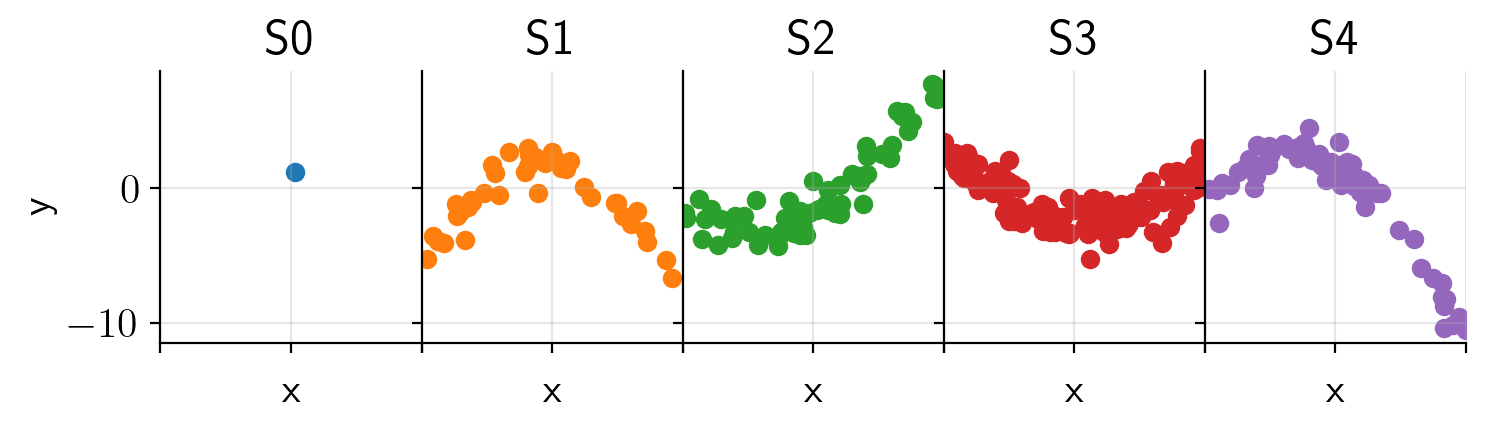

In [6]:
fig, axs = plt.subplots(1, n_segments, sharey=True, figsize=(6.4 * 1.2, 4.8 * 0.5))
axs = axs.ravel()

for n in np.arange(n_segments):
    axs[n].set_title(f"S{n}")
    color = cmap[n]
    ixs = jnp.where(segment == n)[0]
    xsub = hist_dpg["x"][ixs, :, 1]
    ysub = hist_dpg["y"][ixs]
    axs[n].scatter(xsub, ysub, color=color)
    axs[n].grid(alpha=0.3)
    axs[n].set_xlabel("x")
    axs[n].set_xlim(-2, 2)
    axs[n].set_xticks([-2, 0, 2], labels=["", "", ""])
axs[0].set_ylabel("y")
plt.tight_layout()
plt.subplots_adjust(wspace=0.0)
plt.savefig("../figures/segments-lr.png", dpi=150)

In [7]:
@partial(jax.vmap, in_axes=(None, 0))
def get_segment_init(segment, n):
    return jnp.where(segment == n, size=len(segment))[0][0] 

In [8]:
segments_init = get_segment_init(segment, jnp.arange(n_segments))
segments_init = np.array(segments_init)

In [9]:
X = hist_dpg["x"]
y = hist_dpg["y"]

## Problem formulation

Observation model
$$
    p(y_t \vert \boldsymbol\theta_t, {\bf x}_t) = {\cal N}(y_t \vert {\bf x}_t^\intercal\boldsymbol\theta_t, \beta)
$$

with known observation precision $\tau$ and prior
$$
    p(\boldsymbol\theta_t) = {\cal N}\left(\boldsymbol\theta_t \vert \boldsymbol 0, \alpha^{-1}{\bf I}\right)
$$


In [10]:
n = 2
ixs = jnp.where(segment == n)[0]

beta = 1.0

Xsub = X.squeeze()[ixs]
ysub = y.ravel()[ixs]

In [11]:
beta = 1.0
alpha = 5.0
d = 3
wprior = jnp.zeros(d)
wcov_prior = jnp.eye(d) * alpha

In [12]:
Xsub.shape

(62, 3)

In [13]:
Prec_posterior = alpha * jnp.eye(d) + beta * Xsub.T @ Xsub
mean_posterior = beta * jnp.linalg.inv(Prec_posterior) @ Xsub.T @ ysub

In [14]:
xtest = np.linspace(-2, 2, 200)

@jax.vmap
def phi(x): return jnp.array([1, x, x ** 2])

Phi_test = phi(xtest)

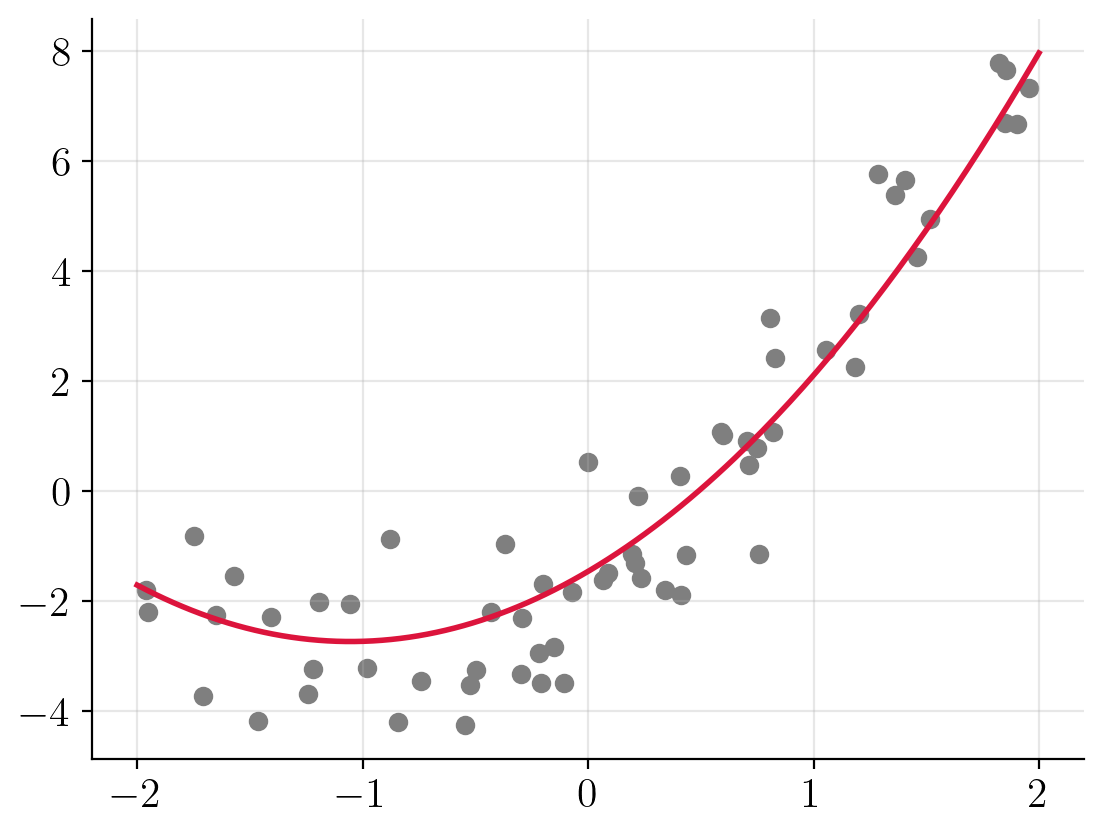

In [15]:
plt.scatter(Xsub[:, 1], ysub, c="tab:gray")
plt.plot(xtest, Phi_test @ mean_posterior, c="crimson", linewidth=2)

plt.grid(alpha=0.3)

### The components

**The predictive probability**

$$
\begin{aligned}
    p(\boldsymbol y_t \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t)
    &= \int p(\boldsymbol y_t, \boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma, {\bf x}_t) d\boldsymbol\theta\\
    &= \int p(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)p(\boldsymbol y_t \vert \boldsymbol\theta, {\bf x}_t)d\boldsymbol\theta\\
    &= \int {\cal N}(\boldsymbol\theta \vert \boldsymbol\mu, \boldsymbol\Sigma)
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\theta^\intercal {\bf x}_t, \beta^{-1})d\boldsymbol\theta\\
    &=
    {\cal N}(\boldsymbol y_t \vert \boldsymbol\mu^\intercal {\bf x}_t, \beta^{-1} + {\bf x}_t^\intercal\boldsymbol\Sigma{\bf x}_t)
\end{aligned}
$$

## RL-PR

In [18]:
std_measurements = 1.0
def callback(bel, bel_prior, y, X):
    log_posterior = bel_prior.log_joint - jax.nn.logsumexp(bel_prior.log_joint, keepdims=True)
    posterior = jnp.exp(log_posterior)

    pred_values = jax.vmap(applyfn, in_axes=(0, None))(bel_prior.mean, X)
    pred = posterior @ pred_values

    Ht = jnp.atleast_2d(X).T
    print(Ht.shape)
    var_pred = jnp.einsum("nk,knm,mk,k->", Ht, bel_prior.cov, Ht, posterior)
    var_pred = var_pred + std_measurements ** 2
    
    out = {
        "log_joint": bel.log_joint,
        "runlength": bel.runlength,
        "err": pred - y,
        "yhat": pred,
        "yhat_var": var_pred,
        "mean": bel.mean
    }
    return out

In [19]:
def applyfn(w, x):
    return jnp.atleast_1d(w @ x)

In [20]:
base_filter = GaussianFilter(applyfn, dynamics_covariance=0.0, variance=1.0)
agent = ExpfamRLPR(p_change=0.01, K=n_samples, filter=base_filter)

bel_init = agent.init_bel(wprior, 1/alpha, 0.0)
X = jnp.squeeze(X)

In [21]:
bel_final, hist = agent.scan(y, X, bel_init, callback)

(3, 1)


In [22]:
log_posterior = hist["log_joint"] - jax.nn.logsumexp(hist["log_joint"], axis=-1, keepdims=True)
posterior = jnp.exp(log_posterior)

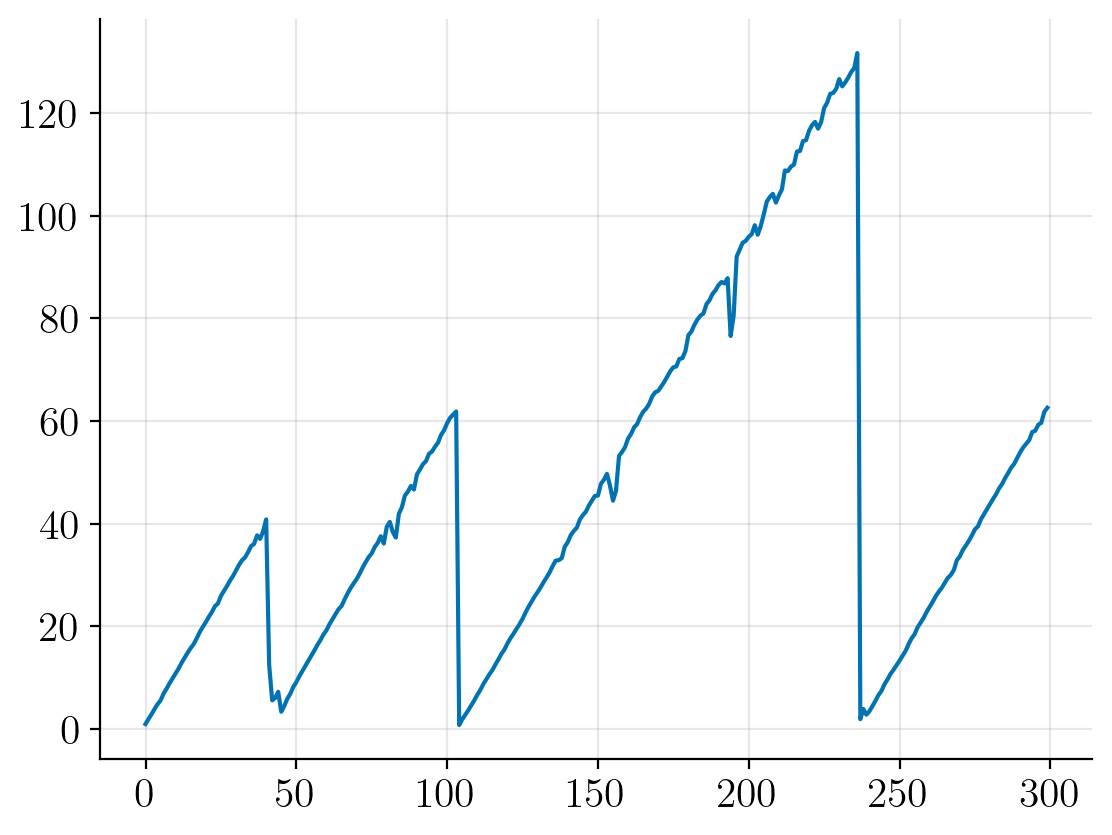

In [23]:
expected_runlength = jnp.einsum("tk,tk->t", hist["runlength"], posterior)
plt.plot(expected_runlength)
plt.grid(alpha=0.3)

In [24]:
log_posterior_grid = np.array(log_posterior)
log_posterior_grid[np.abs(log_posterior_grid) == np.inf] = np.nan

In [25]:
runlenght_hist = hist["runlength"] + np.triu(np.ones((n_samples, n_samples)), k=2) * (n_samples + 1)
ix_sort = np.argsort(runlenght_hist, axis=1)

log_posterior_grid_sort = np.take_along_axis(log_posterior_grid, ix_sort, axis=1)

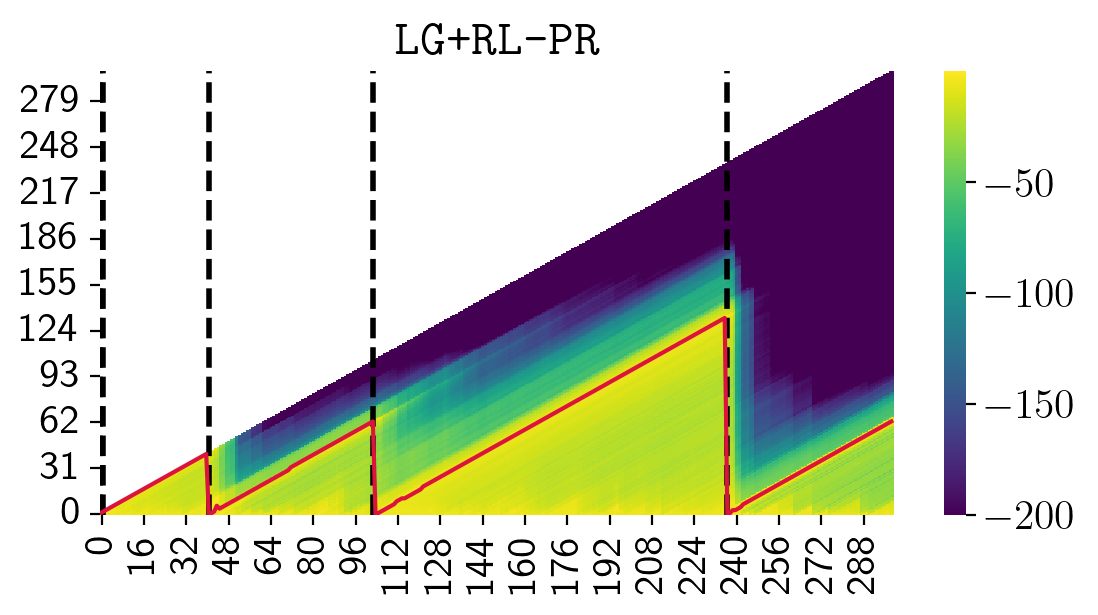

In [26]:
fig, ax = plt.subplots(figsize=(6.4, 4.8 * 0.6))
plt.title(r"$\texttt{LG+RL-PR}$")

T = 300

for s in segments_init:
    plt.axvline(x=s, c="black", linestyle="--", alpha=1.0, linewidth=2)

sns.heatmap(log_posterior_grid_sort[:T, :T].T, cmap="viridis", vmin=-200)
plt.plot(np.nanargmax(log_posterior_grid_sort, axis=1), c="crimson")
plt.gca().invert_yaxis()
plt.savefig("../figures/rl-pr-linreg.png", dpi=300, bbox_inches="tight")

# Animation

In [27]:
from matplotlib.animation import FuncAnimation

In [28]:
Xcpu = np.array(X.squeeze())
ycpu = np.array(y.squeeze())
segment_cpu = np.array(segment)
Phi_test = np.array(Phi_test)
hist_mean = hist["mean"]

In [29]:
hist["mean"].shape

(300, 300, 3)

In [30]:
ixs_segments = {
    n: np.where(segment == n)[0]
    for n in range(n_segments)
}

/tmp/ipykernel_1177613/2759526417.py:20: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


/tmp/ipykernel_1177613/2759526417.py:20: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


/tmp/ipykernel_1177613/2759526417.py:20: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


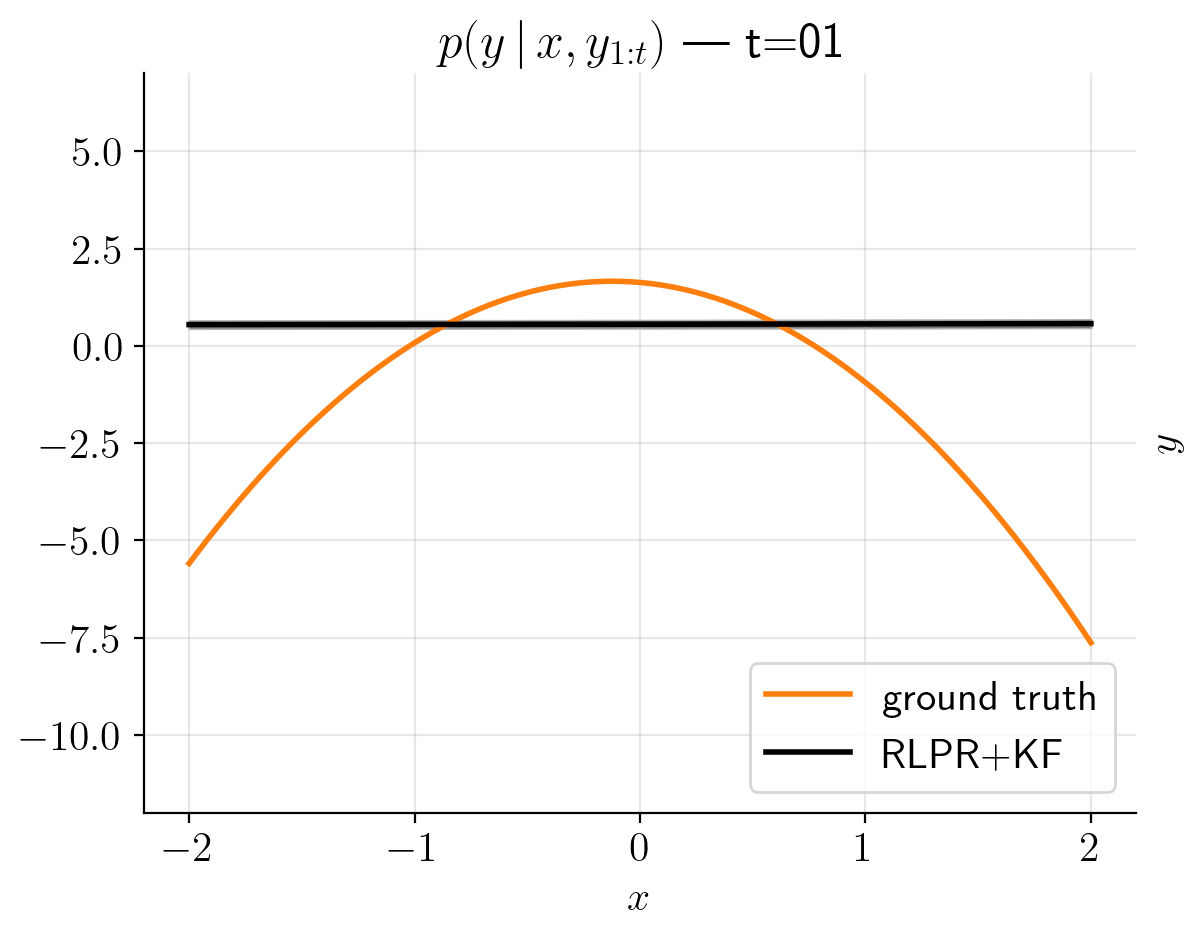

In [31]:
fig, ax = plt.subplots()


xeval = Phi_test[:, 1]
def animate(t):
    ax.cla()
    print(t, end="\r")

    s = segment_cpu[t]
    params_true = np.array(hist_dpg["params"][t])
    t_init = ixs_segments[s][0]
    
    ix_init = 0
    ix_end = t

    ytrue = np.einsum("nm,m->n", Phi_test, params_true)

    yhat = np.einsum("sm,km->sk", Phi_test, hist_mean[t,:t+2])
    yhat_mean = np.einsum("sk,k-> s", yhat, posterior[t,:t+2])
    yhat_std = np.sqrt(
        jnp.einsum("sk,k-> s", yhat ** 2, posterior[t,:t+2]) - yhat_mean ** 2
    )

    tmin = max(0, t - 150)
    alpha_vals = jnp.linspace(0, 1, len(y.squeeze()[tmin:t]))

    plt.plot(xeval, ytrue, c=colors[t], linewidth=2, label="ground truth")
    plt.plot(xeval, yhat_mean, c="black", linewidth=2, label="RLPR+KF")
    plt.fill_between(xeval, yhat_mean - 2 * yhat_std, yhat_mean + 2 * yhat_std, color="black", alpha=0.3)
    
    plt.scatter(Xcpu[tmin:t, 1], ycpu[tmin:t], c=colors[tmin:t], alpha=alpha_vals)
    
    plt.grid(alpha=0.3)
    plt.ylim(-12, 7)
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    ax.yaxis.set_label_position("right")
    plt.title(r"$p(y\,\vert\,x, y_{1:t})$"f" | t={t:02}")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

anim = FuncAnimation(fig, animate, np.arange(1, 300))
anim.save("../figures/bocd-lr-new.gif", fps=10)

/tmp/ipykernel_528107/995757488.py:19: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


/tmp/ipykernel_528107/995757488.py:19: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


/tmp/ipykernel_528107/995757488.py:19: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


/tmp/ipykernel_528107/995757488.py:19: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


/tmp/ipykernel_528107/995757488.py:19: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


/tmp/ipykernel_528107/995757488.py:19: RuntimeWarning: invalid value encountered in sqrt
  yhat_std = np.sqrt(


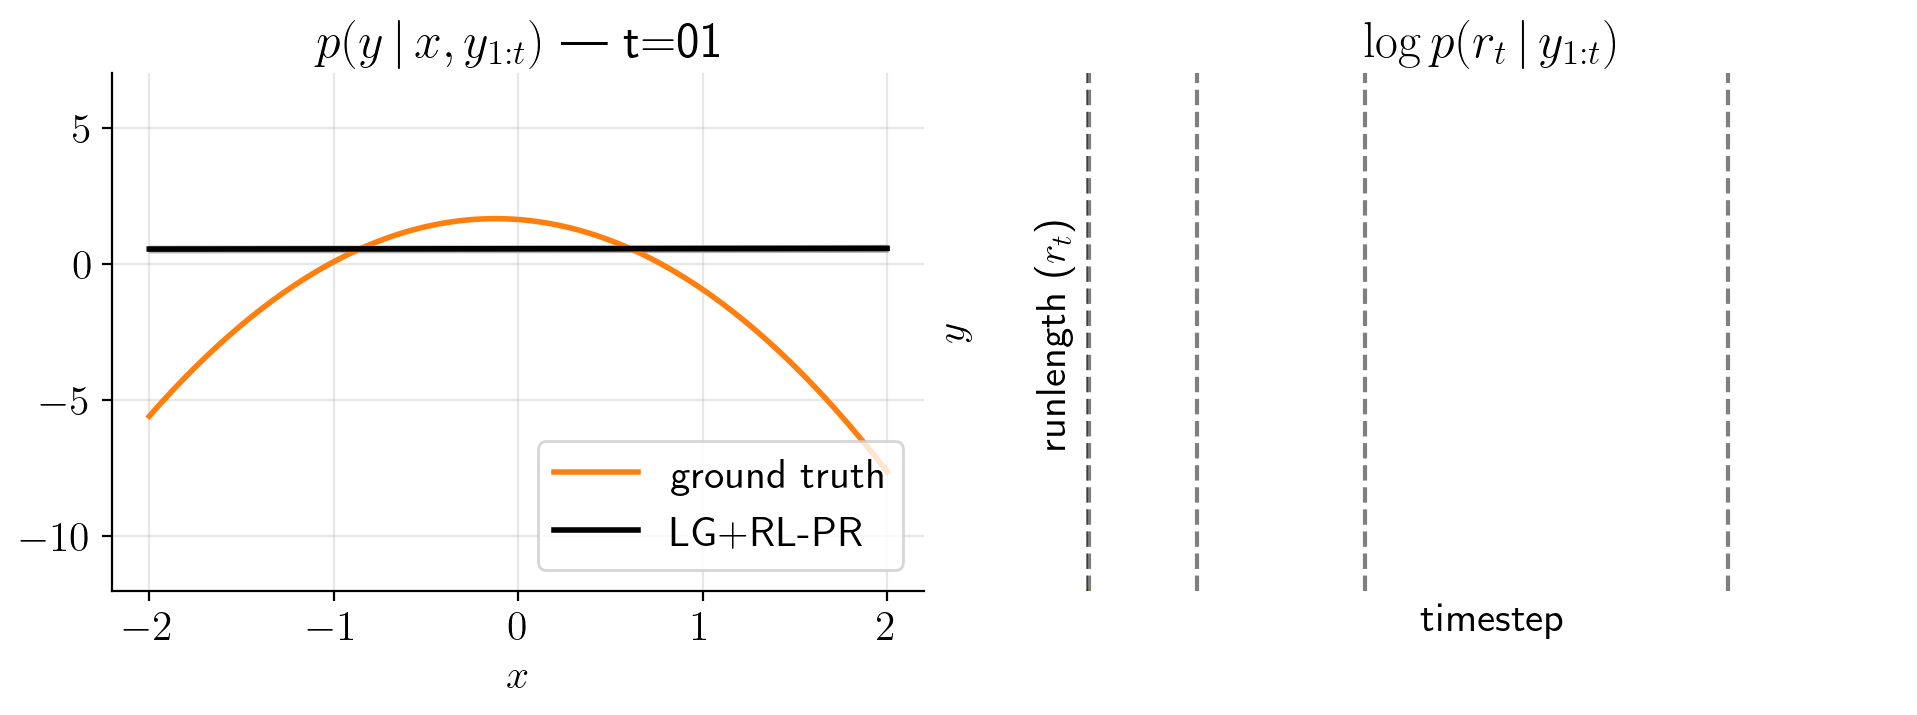

In [199]:
fig, axs = plt.subplots(1, 2, figsize=(6.4 * 1.8, 4.8 * 0.7))

def animate(t):
    for ax in axs:
        ax.cla()
    print(t, end="\r")

    s = segment_cpu[t]
    params_true = hist_dpg["params"][t]
    t_init = ixs_segments[s][0]
    
    ix_init = 0
    ix_end = t

    ytrue = np.einsum("nm,m->n", Phi_test, params_true)

    yhat = np.einsum("sm,km->sk", Phi_test, hist_mean[t,:t+2])
    yhat_mean = np.einsum("sk,k-> s", yhat, posterior[t,:t+2])
    yhat_std = np.sqrt(
        jnp.einsum("sk,k-> s", yhat ** 2, posterior[t,:t+2]) - yhat_mean ** 2
    )

    tmin = max(0, t - 150)
    alpha_vals = jnp.linspace(0, 1, len(y.squeeze()[tmin:t]))

    axs[0].plot(xeval, ytrue, c=colors[t], linewidth=2, label="ground truth")
    axs[0].plot(xeval, yhat_mean, c="black", linewidth=2, label="LG+RL-PR")
    axs[0].fill_between(xeval, yhat_mean - 2 * yhat_std, yhat_mean + 2 * yhat_std, color="black", alpha=0.3)
    
    axs[0].scatter(Xcpu[tmin:t, 1], ycpu[tmin:t], c=colors[tmin:t], alpha=alpha_vals)
    
    axs[0].grid(alpha=0.3)
    axs[0].set_ylim(-12, 7)
    axs[0].set_xlabel("$x$")
    axs[0].set_ylabel("$y$")
    axs[0].yaxis.set_label_position("right")
    axs[0].set_title(r"$p(y\,\vert\,x, y_{1:t})$"f" | t={t:02}")
    axs[0].legend(loc="lower right")
    axs[0].grid(alpha=0.3)
    axs[0].set_xlabel("$x$")
    axs[0].set_ylabel("$y$")

    sns.heatmap(
        log_posterior_grid_sort.T[:t, :t], cbar=False, vmin=-200, cmap="viridis", ax=axs[1], xticklabels=False, yticklabels=False
    )
    plt.plot(np.nanargmax(log_posterior_grid_sort[:t], axis=1), c="crimson")
    axs[1].invert_yaxis()
    axs[1].set_xlim(0, 300)
    axs[1].set_ylim(0, 300)
    
    for s in segments_init:
        axs[1].axvline(x=s, c="black", linestyle="--", alpha=0.5)
    axs[1].set_xlabel("timestep")
    axs[1].set_ylabel("runlength ($r_{t}$)")
    axs[1].set_title(r"$\log p(r_{t}\,\vert\,y_{1:t})$")

# animate(50)
anim = FuncAnimation(fig, animate, np.arange(1, 300))
anim.save("../figures/bocd-lr-and-prob.gif", fps=10)